In [ ]:
data_dir = "/content/drive/MyDrive/Quora-Data/"

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
with open(data_dir + "pre-processing/glove_twiiter_100_max_train", "rb") as f:
    X_train_max = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_max_test", "rb") as f:
    X_test_max = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_train", "rb") as f:
    X_train_avg = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_test", "rb") as f:
    X_test_avg = pickle.load(f)
Y_train = pd.read_csv(data_dir + "pre-processing/train.csv")["Y"].values
Y_test = pd.read_csv(data_dir + "pre-processing/test.csv")["Y"].values

X_train, X_test = X_train_max, X_test_max

def remove_nan(X, Y):
    Y = Y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    return X, Y

X_train, Y_train = remove_nan(X_train, Y_train)
X_test, Y_test = remove_nan(X_test, Y_test)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

X_train_t = torch.from_numpy(X_train.astype('float32'))
X_test_t = torch.from_numpy(X_test.astype('float32'))
X_val_t = torch.from_numpy(X_val.astype('float32'))
Y_train_t = torch.from_numpy(Y_train)
Y_test_t = torch.from_numpy(Y_test)
Y_val_t = torch.from_numpy(Y_val)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
iteration_list_val = []
iteration_list_train = []
loss_train_epoch = []

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(200, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 1)
    #torch.nn.Sigmoid()
    #torch.nn.Softmax()
)
# inp_dim = 200
# class Net(nn.Module):
#     def __init__(self, input_shape):
#         super(Net,self).__init__()
#         self.fc1 = nn.Linear(input_shape, 120)
#         self.fc2 = nn.Linear(120, 80)
#         self.fc3 = nn.Linear(80, 1)

#     def forward(self,x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x
# model = Net(input_shape=inp_dim)

model.to(device)
num_epochs = 100
count = 0
batch_size = 100

class MyDataset(Dataset):
    def __init__(self, X, Y, transform = None):
        self.transform = transform
        self.X = torch.tensor(X, dtype=torch.float32) #X
        self.Y = torch.tensor(Y, dtype=torch.float32) #torch.from_numpy(np.asarray(Y).astype('long'))

    def __getitem__(self, index):
        label = self.Y[index]
        image = self.X[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.X)

error = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()

# After running several times, this was found to be the best
learning_rate = 0.001
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=0.008)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 500, Val Loss: 371.926, Val Accuracy: 0.698 Train Loss: 1481.267, Train Accuracy: 0.700
Iteration: 1000, Val Loss: 366.218, Val Accuracy: 0.706 Train Loss: 1457.619, Train Accuracy: 0.710
Iteration: 1500, Val Loss: 360.587, Val Accuracy: 0.710 Train Loss: 1431.933, Train Accuracy: 0.714
Iteration: 2000, Val Loss: 359.016, Val Accuracy: 0.714 Train Loss: 1423.476, Train Accuracy: 0.718
Iteration: 2500, Val Loss: 349.855, Val Accuracy: 0.720 Train Loss: 1389.530, Train Accuracy: 0.726
Iteration: 3000, Val Loss: 352.215, Val Accuracy: 0.719 Train Loss: 1394.482, Train Accuracy: 0.723
Iteration: 3500, Val Loss: 345.502, Val Accuracy: 0.725 Train Loss: 1364.474, Train Accuracy: 0.731
Iteration: 4000, Val Loss: 342.711, Val Accuracy: 0.729 Train Loss: 1356.276, Train Accuracy: 0.735
Iteration: 4500, Val Loss: 345.078, Val Accuracy: 0.724 Train Loss: 1362.816, Train Accuracy: 0.730
Iteration: 5000, Val Loss: 340.790, Val Accuracy: 0.731 Train Loss: 1347.305, Train Accuracy: 0.736
I

KeyboardInterrupt: ignored

In [ ]:
#learning_rate = 1
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adagrad(model.parameters(), weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 13500, Val Loss: 336.725, Val Accuracy: 0.733 Train Loss: 1326.357, Train Accuracy: 0.739
Iteration: 14000, Val Loss: 330.061, Val Accuracy: 0.740 Train Loss: 1297.210, Train Accuracy: 0.746
Iteration: 14500, Val Loss: 327.270, Val Accuracy: 0.741 Train Loss: 1283.256, Train Accuracy: 0.750
Iteration: 15000, Val Loss: 324.295, Val Accuracy: 0.748 Train Loss: 1274.341, Train Accuracy: 0.754
Iteration: 15500, Val Loss: 324.603, Val Accuracy: 0.749 Train Loss: 1273.927, Train Accuracy: 0.757
Iteration: 16000, Val Loss: 322.472, Val Accuracy: 0.750 Train Loss: 1265.041, Train Accuracy: 0.757
Iteration: 16500, Val Loss: 323.108, Val Accuracy: 0.748 Train Loss: 1264.743, Train Accuracy: 0.756
Iteration: 17000, Val Loss: 322.974, Val Accuracy: 0.749 Train Loss: 1263.977, Train Accuracy: 0.758
Iteration: 17500, Val Loss: 322.114, Val Accuracy: 0.750 Train Loss: 1260.995, Train Accuracy: 0.758
Iteration: 18000, Val Loss: 321.812, Val Accuracy: 0.752 Train Loss: 1259.795, Train Accura

KeyboardInterrupt: ignored

In [ ]:
#learning_rate = 1
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adagrad(model.parameters(), weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 60000, Val Loss: 329.749, Val Accuracy: 0.745 Train Loss: 1297.430, Train Accuracy: 0.751
Iteration: 65000, Val Loss: 319.236, Val Accuracy: 0.753 Train Loss: 1244.132, Train Accuracy: 0.762
Iteration: 70000, Val Loss: 317.944, Val Accuracy: 0.755 Train Loss: 1236.777, Train Accuracy: 0.764
Iteration: 75000, Val Loss: 318.001, Val Accuracy: 0.756 Train Loss: 1236.191, Train Accuracy: 0.765
Iteration: 80000, Val Loss: 317.406, Val Accuracy: 0.757 Train Loss: 1233.104, Train Accuracy: 0.766
Iteration: 85000, Val Loss: 317.358, Val Accuracy: 0.757 Train Loss: 1232.996, Train Accuracy: 0.767
Iteration: 90000, Val Loss: 317.157, Val Accuracy: 0.756 Train Loss: 1230.880, Train Accuracy: 0.766
Iteration: 95000, Val Loss: 316.914, Val Accuracy: 0.756 Train Loss: 1229.838, Train Accuracy: 0.768
Iteration: 100000, Val Loss: 316.825, Val Accuracy: 0.757 Train Loss: 1228.928, Train Accuracy: 0.767
Iteration: 105000, Val Loss: 317.082, Val Accuracy: 0.755 Train Loss: 1228.919, Train Accu

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 195000, Val Loss: 313.213, Val Accuracy: 0.761 Train Loss: 1202.968, Train Accuracy: 0.772
Iteration: 197500, Val Loss: 311.521, Val Accuracy: 0.761 Train Loss: 1190.062, Train Accuracy: 0.775
Iteration: 200000, Val Loss: 308.564, Val Accuracy: 0.764 Train Loss: 1171.335, Train Accuracy: 0.779
Iteration: 202500, Val Loss: 305.627, Val Accuracy: 0.767 Train Loss: 1153.312, Train Accuracy: 0.784
Iteration: 205000, Val Loss: 304.623, Val Accuracy: 0.768 Train Loss: 1142.077, Train Accuracy: 0.786
Iteration: 207500, Val Loss: 303.846, Val Accuracy: 0.769 Train Loss: 1127.893, Train Accuracy: 0.789
Iteration: 210000, Val Loss: 305.290, Val Accuracy: 0.766 Train Loss: 1124.200, Train Accuracy: 0.791
Iteration: 212500, Val Loss: 302.651, Val Accuracy: 0.768 Train Loss: 1106.588, Train Accuracy: 0.794
Iteration: 215000, Val Loss: 300.618, Val Accuracy: 0.771 Train Loss: 1090.670, Train Accuracy: 0.798
Iteration: 217500, Val Loss: 299.740, Val Accuracy: 0.772 Train Loss: 1080.801, Tr

In [ ]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 245000, Val Loss: 299.118, Val Accuracy: 0.777 Train Loss: 1007.135, Train Accuracy: 0.817
Iteration: 247500, Val Loss: 299.389, Val Accuracy: 0.776 Train Loss: 999.304, Train Accuracy: 0.818
Iteration: 250000, Val Loss: 300.492, Val Accuracy: 0.777 Train Loss: 993.957, Train Accuracy: 0.820
Iteration: 252500, Val Loss: 300.931, Val Accuracy: 0.776 Train Loss: 991.883, Train Accuracy: 0.821
Iteration: 255000, Val Loss: 303.285, Val Accuracy: 0.774 Train Loss: 997.906, Train Accuracy: 0.820
Iteration: 257500, Val Loss: 301.276, Val Accuracy: 0.777 Train Loss: 984.040, Train Accuracy: 0.823
Iteration: 260000, Val Loss: 302.731, Val Accuracy: 0.776 Train Loss: 984.894, Train Accuracy: 0.823
Iteration: 262500, Val Loss: 302.258, Val Accuracy: 0.775 Train Loss: 979.892, Train Accuracy: 0.824
Iteration: 265000, Val Loss: 304.498, Val Accuracy: 0.773 Train Loss: 983.980, Train Accuracy: 0.823


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 267500, Val Loss: 299.096, Val Accuracy: 0.777 Train Loss: 968.720, Train Accuracy: 0.826
Iteration: 270000, Val Loss: 296.412, Val Accuracy: 0.778 Train Loss: 973.255, Train Accuracy: 0.826
Iteration: 272500, Val Loss: 295.129, Val Accuracy: 0.778 Train Loss: 979.584, Train Accuracy: 0.826
Iteration: 275000, Val Loss: 294.124, Val Accuracy: 0.778 Train Loss: 985.110, Train Accuracy: 0.826
Iteration: 277500, Val Loss: 293.629, Val Accuracy: 0.779 Train Loss: 990.843, Train Accuracy: 0.824
Iteration: 280000, Val Loss: 293.593, Val Accuracy: 0.779 Train Loss: 996.470, Train Accuracy: 0.823
Iteration: 282500, Val Loss: 293.156, Val Accuracy: 0.779 Train Loss: 998.535, Train Accuracy: 0.823
Iteration: 285000, Val Loss: 293.080, Val Accuracy: 0.779 Train Loss: 1001.791, Train Accuracy: 0.823
Iteration: 287500, Val Loss: 293.224, Val Accuracy: 0.779 Train Loss: 1006.091, Train Accuracy: 0.820
Iteration: 290000, Val Loss: 292.750, Val Accuracy: 0.780 Train Loss: 1006.938, Train Acc

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.000005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 307500, Val Loss: 292.774, Val Accuracy: 0.779 Train Loss: 1014.355, Train Accuracy: 0.819
Iteration: 310000, Val Loss: 292.880, Val Accuracy: 0.779 Train Loss: 1006.687, Train Accuracy: 0.820
Iteration: 312500, Val Loss: 293.147, Val Accuracy: 0.779 Train Loss: 1000.911, Train Accuracy: 0.821
Iteration: 315000, Val Loss: 293.450, Val Accuracy: 0.779 Train Loss: 995.978, Train Accuracy: 0.822
Iteration: 317500, Val Loss: 293.746, Val Accuracy: 0.779 Train Loss: 992.117, Train Accuracy: 0.822
Iteration: 320000, Val Loss: 294.208, Val Accuracy: 0.779 Train Loss: 989.082, Train Accuracy: 0.822
Iteration: 322500, Val Loss: 294.629, Val Accuracy: 0.779 Train Loss: 986.171, Train Accuracy: 0.822
Iteration: 325000, Val Loss: 295.164, Val Accuracy: 0.779 Train Loss: 983.564, Train Accuracy: 0.823


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 327500, Val Loss: 295.231, Val Accuracy: 0.778 Train Loss: 982.389, Train Accuracy: 0.823
Iteration: 330000, Val Loss: 295.316, Val Accuracy: 0.778 Train Loss: 981.868, Train Accuracy: 0.824
Iteration: 332500, Val Loss: 295.378, Val Accuracy: 0.778 Train Loss: 981.376, Train Accuracy: 0.823
Iteration: 335000, Val Loss: 295.455, Val Accuracy: 0.779 Train Loss: 980.899, Train Accuracy: 0.823
Iteration: 337500, Val Loss: 295.531, Val Accuracy: 0.779 Train Loss: 980.461, Train Accuracy: 0.823
Iteration: 340000, Val Loss: 295.603, Val Accuracy: 0.779 Train Loss: 980.038, Train Accuracy: 0.824
Iteration: 342500, Val Loss: 295.677, Val Accuracy: 0.779 Train Loss: 979.635, Train Accuracy: 0.824
Iteration: 345000, Val Loss: 295.785, Val Accuracy: 0.778 Train Loss: 979.237, Train Accuracy: 0.824


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.0000001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 350000, Val Loss: 295.861, Val Accuracy: 0.778 Train Loss: 978.765, Train Accuracy: 0.824
Iteration: 352500, Val Loss: 295.870, Val Accuracy: 0.778 Train Loss: 978.711, Train Accuracy: 0.824
Iteration: 355000, Val Loss: 295.882, Val Accuracy: 0.778 Train Loss: 978.658, Train Accuracy: 0.824
Iteration: 357500, Val Loss: 295.892, Val Accuracy: 0.778 Train Loss: 978.605, Train Accuracy: 0.824
Iteration: 360000, Val Loss: 295.901, Val Accuracy: 0.778 Train Loss: 978.555, Train Accuracy: 0.824
Iteration: 362500, Val Loss: 295.914, Val Accuracy: 0.778 Train Loss: 978.503, Train Accuracy: 0.824
Iteration: 365000, Val Loss: 295.925, Val Accuracy: 0.778

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training set Loss-Epoch')

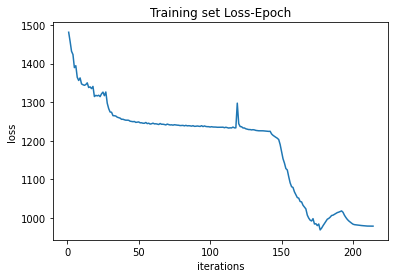

In [ ]:
loss_train_epoch_m = [i.item() for i in loss_train_epoch]
plt.plot([i+1 for i in range(len(iteration_list_train))], loss_train_epoch_m)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Training set Loss-Epoch")

Text(0.5, 1.0, 'Validation set Loss-iteration')

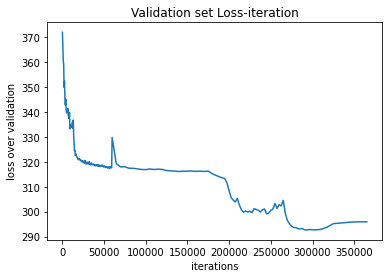

In [ ]:
loss_list_val_m = [i.item() for i in loss_list_val]
plt.plot(iteration_list_val, loss_list_val_m)
plt.xlabel("iterations")
plt.ylabel("loss over validation")
plt.title("Validation set Loss-iteration")

Text(0.5, 1.0, 'Validation set Accuracy-iteration')

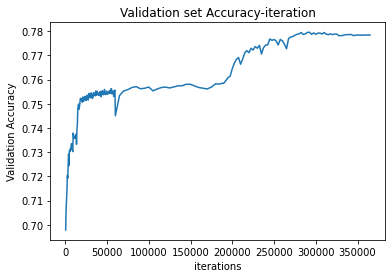

In [ ]:
accuracy_list_val_m = [i for i in accuracy_list_val]
plt.plot(iteration_list_val, accuracy_list_val_m)
plt.xlabel("iterations")
plt.ylabel("Validation Accuracy")
plt.title("Validation set Accuracy-iteration")

Text(0.5, 1.0, 'Training set Accuracy-iteration')

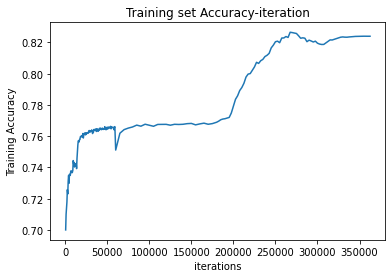

In [ ]:
accuracy_list_train_m = [i for i in accuracy_list_train]
plt.plot(iteration_list_train, accuracy_list_train_m)
plt.xlabel("iterations")
plt.ylabel("Training Accuracy")
plt.title("Training set Accuracy-iteration")

In [ ]:
with open(data_dir + "Models/glove_twitter_max_fc.sav", "wb") as f:
    pickle.dump(model, f)

Test Accuracy: 0.7772020084592742, Test Loss: 373.50067138671875
Test Confusion Matrix
Test AUC:  0.8517501677460888


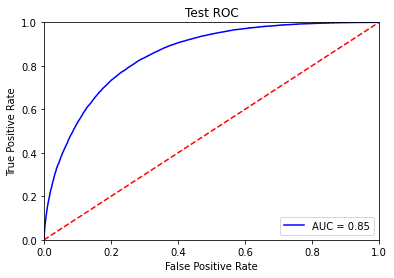

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82     51128
         1.0       0.70      0.69      0.70     29730

    accuracy                           0.78     80858
   macro avg       0.76      0.76      0.76     80858
weighted avg       0.78      0.78      0.78     80858



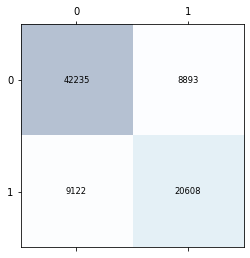

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(test_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Test Accuracy: {}, Test Loss: {}".format(accuracy, loss))
print("Test Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Test AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Test ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Val Accuracy: 0.7784253404857235, Val Loss: 295.9245910644531
Val Confusion Matrix
Val AUC:  0.8554097352256509


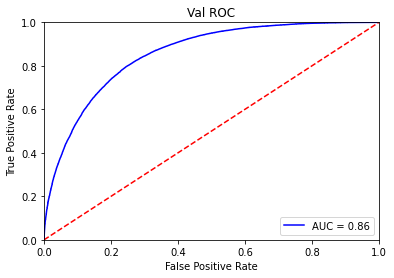

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82     40516
         1.0       0.71      0.69      0.70     24171

    accuracy                           0.78     64687
   macro avg       0.76      0.76      0.76     64687
weighted avg       0.78      0.78      0.78     64687



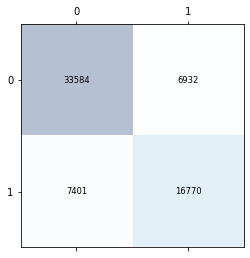

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Val Accuracy: {}, Val Loss: {}".format(accuracy, loss))
print("Val Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Val AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Val ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Train Accuracy: 0.8239231675974414, Train Loss: 978.4545288085938
Train Confusion Matrix
Train AUC:  0.9033527330448237


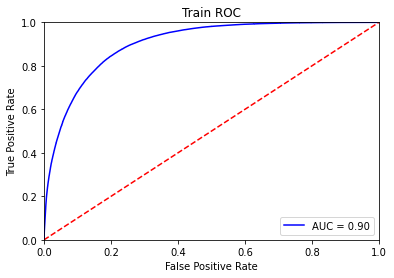

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86    163383
         1.0       0.76      0.76      0.76     95362

    accuracy                           0.82    258745
   macro avg       0.81      0.81      0.81    258745
weighted avg       0.82      0.82      0.82    258745



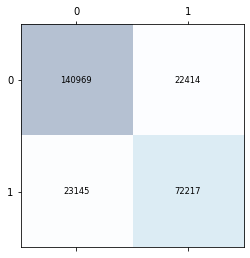

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(train_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Train Accuracy: {}, Train Loss: {}".format(accuracy, loss))
print("Train Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Train AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Train ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

In [ ]:
interm_model = nn.Sequential(*list(model.children())[:-1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


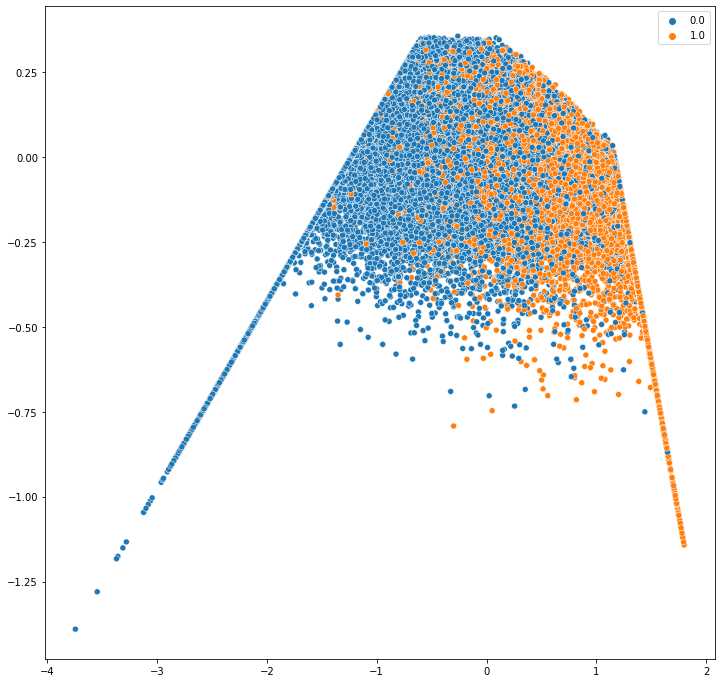

In [ ]:
total = 0
correct = 0
loss = 0
out = []
labels_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = interm_model(test)
    labels_l.append(labels)
    out.append(outputs)

class pca:
    def __init__(self, n_components):
        """
        :param n_components: Number of principal components the data should be reduced too.
        """
        self.components = n_components

    def fit_transform(self, X):
        """
        * Centering our inputs with mean
        * Finding covariance matrix using centered tensor
        * Finding eigen value and eigen vector using torch.eig()
        * Sorting eigen values in descending order and finding index of high eigen values
        * Using sorted index, get the eigen vectors
        * Tranforming the Input vectors with n columns into PCA components with reduced dimension
        :param X: Input tensor with n columns.
        :return: Output tensor with reduced principal components
        """
        centering_X = X - torch.mean(X, dim=0)
        covariance_matrix = torch.mm(centering_X.T, centering_X)/(centering_X.shape[0] - 1)
        eigen_values, eigen_vectors = torch.eig(covariance_matrix, eigenvectors=True)
        eigen_sorted_index = torch.argsort(eigen_values[:,0],descending=True)
        eigen_vectors_sorted = eigen_vectors[:,eigen_sorted_index]
        component_vector = eigen_vectors_sorted[:,0:self.components]
        transformed = torch.mm(component_vector.T, centering_X.T).T
        return transformed
pca_out = pca(n_components=2).fit_transform(torch.cat(out))
pca_vector = pca_out
plt.figure(figsize=(12, 12))
sb.scatterplot(
    pca_vector[:, 0].detach().cpu(), 
    pca_vector[:, 1].detach().cpu(), 
    hue=torch.cat(labels_l).detach().cpu(), 
    #s=100, 
    palette="tab10"
)
plt.show()